## Start measurments

In [1]:
#%matplotlib notebook
import os, time, sys
import importlib
import tables as tb
import matplotlib.pyplot as plt
import numpy as np
import panda2.panda2 as panda2

import panda2.analysis.fitfunctions as fitfunc
import panda2.scans.injection_scan as injection_scan


# run "ping" command
!ping -c 1 192.168.10.16

# instancíate a Panda2 class
dut = panda2.Panda2()
# read yaml file and connect to FPGA
dut.init()
dut.set_sync(auto_sync=True)  ## do not delete this


PING 192.168.10.16 (192.168.10.16) 56(84) bytes of data.
64 bytes from 192.168.10.16: icmp_seq=1 ttl=64 time=0.102 ms

--- 192.168.10.16 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 0.102/0.102/0.102/0.000 ms


2024-05-17 20:32:29,723 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing spi_inj (firmware version: 2), module basil.HL.spi, base_addr 0x10
2024-05-17 20:32:29,724 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing inj (firmware version: 1), module panda2.pulse_gen_div, base_addr 0x100
2024-05-17 20:32:29,725 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing sync (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x140
2024-05-17 20:32:29,726 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing gate (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x180
2024-05-17 20:32:29,727 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing ts_inj (firmware version: 1), module panda2.timestamp_div, base_addr 0x1c0
2024-05-17 20:32:29,727 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing gpio (firmware version: 0), module basil.HL.gpio, base_addr 0x200
20

## Change settings (global, tdac, comp_en/dis etc)

In [5]:
# define col, row
col, row = 16, 30
### configure chip and enable injection
dut.set_en_inj([col, row])

# this is for Injection card
dut.set_inj_amp(1.0)

# set ampout ON
dut.set_en_ampout([])


### inj_n: number of pulses to be injected. 0=continuous injection
# 1 = 1 clock of 40MHz = 25ns
dut.set_inj(inj_n=100, inj_width=1024*8, inj_delay=1024*8, ext=True)
dut.inject()

#hui
## set all tdac to 0
dut.set_tdac(7, comp='fast')
### slow comp
tdac1 = np.copy(dut.PixelConf['tdac1'])
tdac1[:, :] = 7    # until 7
dut.set_tdac(tdac1, comp='slow')
VDACTh2=160+26#ivan was 150
#VDACTh2=250#150+26

##fast comp
tdac0 = np.copy(dut.PixelConf['tdac0'])
#tdac0[:, :] = 7   # until 7
#dut.set_tdac(tdac0, comp='fast')
#VDACTh=150 #150
VDACTh=250 #150

# sets VDAC and DAC
dut.set_conf(VDACTh=VDACTh,  # fast comparator, 255= very high (alomost off)
             VDACTh2=VDACTh2, # slow comparator, ~128 =  a bit higher than VDACBL 
             VDACBL=102+26,  # base line ~100~128 
             VNComp=10, # default =10
             VNComp2=0,
             VN=32, 
             INFoll2=20, 
             hidrEnB=1,   #1 disalbe, 0 enalbe
             IBLRes=1,    # R of Bl
             IPDAC=10,   # step of TDAC default default value=8, TDAC off = 0, ivan was 16
             VNLVDS = 20,
             VNLVDSDel = 0,
             Invert = 1,
             VPDcl = 32,
             VNDcl = 32,
                        # TDAC=7 no offset, TDAC=0 max negative offset
            )  ## set lowest (largest in number) threshold
            # IPDAC until 63
# sets comparator 
en_comp = np.copy(dut.PixelConf['en_comp0'])
### set all comp off
en_comp[:,:] = 0
dut.set_en_comp(en_comp, comp='fast')
### set comp1 col=10, row=0 ON
en_comp[col, row] = 1
#hui
dut.set_en_comp(en_comp, comp='slow')
                #comp='slow')  ## 0= fast comp, 1 = slow

dut.set_en_hitbus([])

# set_sync: set SyncRes
dut.set_sync(auto_sync=True)

# set timestamp module ON
dut.set_ts_inj(True)

# set the data reciever ON
dut.set_rx(True)
# but mask data for this moment
dut['data_rx'].SAMPLING_EDGE=0
dut.mask_rx(True)


2024-05-17 20:32:52,165 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 20:32:52,166 - root - [INFO    ] (MainThread) inj_amp: 4573
2024-05-17 20:32:52,169 - root - [INFO    ] (MainThread) set_en_ampout: en_ampout_col=0x00000000
2024-05-17 20:32:52,174 - root - [INFO    ] (MainThread) set_inj: inj_width=8192 inj_delay=8192 inj_phase=-1 inj_n=100 ext=1
2024-05-17 20:32:52,178 - root - [INFO    ] (MainThread) set_conf:VDACTh=250VDACTh2=186VDACBL=128VNComp=10VNComp2=0VN=32INFoll2=20hidrEnB=1IBLRes=1IPDAC=10VNLVDS=20VNLVDSDel=0Invert=1VPDcl=32VNDcl=32
2024-05-17 20:32:52,181 - root - [INFO    ] (MainThread) set_en_hitbus: en_hitbus_col=0x1fffffff
2024-05-17 20:32:52,284 - root - [INFO    ] (MainThread) set_sync: sync_period=0x1000000 repeat=0 auto-

2024-05-17 19:29:45,937 - root - [WARNING ] (MainThread) set_inj_amp: fail to set inj_amp=-87DAU, inj_amp must be 0-1.8V(9830DAU)
2024-05-17 19:29:45,940 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-17 19:29:45,940 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 19:29:45,940 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_19:29:45
2024-05-17 19:29:45,990 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 19:29:46,117 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 19:29:46,444 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:29:46,548 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 19:29:46,549 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 19:29:46,551 - root - [INFO    ] (MainThread) SRAM FIFO size: 44
2024-05-17 19:29:46,552 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 19:29:46,553

2024-05-17 19:29:52,906 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=18
2024-05-17 19:29:52,906 - root - [INFO    ] (MainThread) 0.00s hit=1642/1642 event=1624 ts=3600/3600
2024-05-17 19:29:52,907 - root - [INFO    ] (MainThread) alingned to timestamp /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/injection_scan/20240517_192945_injection_hit.h5


0.26s 18942/18942 hit=1642 ts=3600
th=0.116 th_sigma=0.004 Vinj


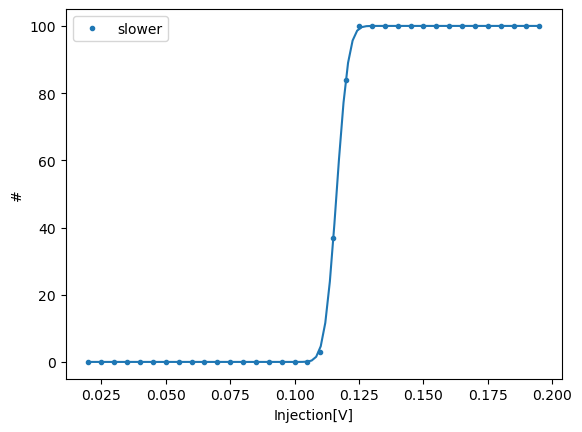

In [196]:
### only one selected pixel

dut.set_inj_amp(0.001, 'V')  # set amp to 200mV  
scan = injection_scan.InjectionScan(dut=dut)
fraw = scan.start(inj=np.arange(0.02, 0.2, 0.005), 
                  cols=None, 
                  rows=None)
fhit = scan.analyze()


## get data from hit file (event_data)
with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator0
dat0 = dat[dat['comp']==0]
if len(dat0)!=0:
    ## take only the first data (delete hits from the rising edges)
    uni, idx= np.unique(dat0['timestamp'], return_index=True)
    dat0 = dat0[idx]
    ## count hits per event_number
    nhit = np.bincount(dat0['event_number'])
    fit = fitfunc.fit_scurve(param['inj'], nhit, reverse=False)
    x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
    plt.plot(x, fitfunc.scurve(x,*fit[:3]), '-')

    # make a plot (injection vs n of hits)
    plt.plot(param['inj'], nhit, '.', label='faster')

## select hits from comparator1
dat1 = dat[dat['comp']==1]
if len(dat1)!=0:
#print(dat1)
    uni, idx = np.unique(dat1['timestamp'], return_index=True)
    dat1 = dat1[idx]
    nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))
    fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
    x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
    plt.plot(x, fitfunc.scurve(x,*fit[:3]), '-')
    plt.plot(param['inj'], nhit1, 'C0.', label='slower')

## show x-axis and y-axis and legend
plt.xlabel('Injection[V]')
plt.ylabel('#')
plt.legend()

## print threshold
print('th={0:.3f} th_sigma={1:.3f} Vinj'.format(fit[1], fit[2]))




### Multiple pixels

In [6]:
## 9 pixels


##tdac1[:,:]=7
for t in [7,6,5,4,3,2,1,0]:
    for col in [14,15,16]:   #range(dut.ncols):
        for row in [30, 31, 32]:    #range(dut.nrows):
            dut.set_en_inj([col, row])

            tdac1[:,:]=7
            tdac1[col, row] = t
            dut.set_tdac(tdac1, comp='slow')

            dut.set_conf()

            en_comp[:,:] = 0
            en_comp[col, row] = 1
            dut.set_en_comp(en_comp, comp='slow')  ##hui 0= fast comp, 1 = slow 

            alg=0
            while alg!=1:
                alg = dut.set_rx(True)

            #time.sleep(1000 / 1000)
            print(col, row, t)
            dut.set_inj_amp(0.015, 'V')  # set amp to 200mV  
            scan = injection_scan.InjectionScan(dut=dut)
            fraw = scan.start(inj=np.arange(0.015, 0.2, 0.005), 
                              cols=None, 
                              rows=None)

2024-05-17 20:34:04,880 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 20:34:04,884 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:34:04,891 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:34:05,008 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:05,011 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:05,012 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:34:05,013 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:34:05
2024-05-17 20:34:05,072 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=

14 30 7


2024-05-17 20:34:05,217 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 0
2024-05-17 20:34:05,351 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:05,454 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:34:05,455 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:34:05,456 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:34:05,457 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:34:05,459 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:34:05,460 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:34:05,464 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:34:05,468 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:05,593 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:34:05,598 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:34:05,764 - root - [

2024-05-17 20:34:11,718 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:34:11,868 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:11,872 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:11,874 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:34:11,875 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:34:11
2024-05-17 20:34:11,930 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


14 31 7


2024-05-17 20:34:12,089 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:34:12,423 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:12,526 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:34:12,527 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:34:12,529 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:34:12,530 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:34:12,531 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:34:12,531 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:34:12,534 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:34:12,537 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:12,671 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:34:12,676 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:34:12,832 - root - 

2024-05-17 20:34:18,788 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:34:18,903 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:18,904 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:18,904 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:34:18,905 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:34:18
2024-05-17 20:34:18,951 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:34:19,077 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32


14 32 7


2024-05-17 20:34:19,412 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:19,514 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:34:19,515 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:34:19,516 - root - [INFO    ] (MainThread) SRAM FIFO size: 32
2024-05-17 20:34:19,517 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:34:19,517 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:34:19,518 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:34:19,519 - root - [WARNING ] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 32
2024-05-17 20:34:19,523 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:34:19,528 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:19,662 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=8
2024-05-17 20:34:19,667 - root - [INFO    ] (MainThread) inj_amp: 49
2024-

2024-05-17 20:34:25,782 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:34:25,899 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:25,901 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:25,901 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:34:25,902 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:34:25
2024-05-17 20:34:25,970 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


15 30 7


2024-05-17 20:34:26,118 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:34:26,444 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:26,547 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:34:26,548 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:34:26,548 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:34:26,549 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:34:26,549 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:34:26,550 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:34:26,551 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:34:26,555 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:26,689 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:34:26,694 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:34:26,857 - root - 

2024-05-17 20:34:32,829 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:34:32,977 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:32,981 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:32,982 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:34:32,983 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:34:32
2024-05-17 20:34:33,047 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:34:33,176 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32


15 31 7


2024-05-17 20:34:33,500 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:33,604 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:34:33,605 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:34:33,606 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:34:33,607 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:34:33,608 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:34:33,609 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:34:33,613 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:34:33,615 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:33,748 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:34:33,754 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:34:33,910 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:34:33,914 - roo

2024-05-17 20:34:40,013 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:40,016 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:40,022 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:34:40,023 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:34:40
2024-05-17 20:34:40,085 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:34:40,211 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32


15 32 7


2024-05-17 20:34:40,567 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:40,670 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:34:40,672 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:34:40,673 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:34:40,673 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:34:40,674 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:34:40,674 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:34:40,677 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:34:40,680 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:40,812 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:34:40,817 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:34:40,982 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:34:40,988 - roo

2024-05-17 20:34:47,075 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:47,080 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:47,081 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:34:47,083 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:34:47
2024-05-17 20:34:47,141 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


16 30 7


2024-05-17 20:34:47,279 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:34:47,615 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:47,720 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:34:47,722 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:34:47,723 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:34:47,726 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:34:47,727 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:34:47,728 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:34:47,732 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:34:47,738 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:47,862 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:34:47,866 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:34:48,033 - root - 

2024-05-17 20:34:53,993 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:34:54,134 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:54,139 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:54,141 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:34:54,143 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:34:54
2024-05-17 20:34:54,205 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:34:54,332 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 12


16 31 7


2024-05-17 20:34:54,670 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:34:54,773 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:34:54,775 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:34:54,776 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:34:54,777 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:34:54,778 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:34:54,779 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:34:54,781 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:34:54,785 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:34:54,917 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:34:54,923 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:34:55,081 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:34:55,088 - roo

2024-05-17 20:35:01,166 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:01,169 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:01,170 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:35:01,171 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:35:01
2024-05-17 20:35:01,268 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


16 32 7


2024-05-17 20:35:01,395 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:35:01,736 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:01,839 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:35:01,840 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:35:01,840 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:35:01,841 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:35:01,841 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:35:01,841 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:35:01,842 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:35:01,843 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:01,986 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:35:01,992 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:35:02,148 - root - 

2024-05-17 20:35:08,119 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:08,124 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:08,254 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:08,258 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:08,259 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:35:08,260 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:35:08
2024-05-17 20:35:08,327 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:35:08,453 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 0


14 30 6


2024-05-17 20:35:08,581 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:08,685 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:35:08,687 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:35:08,689 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:35:08,691 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:35:08,693 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:35:08,694 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:35:08,697 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:35:08,701 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:08,825 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:35:08,829 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:35:08,994 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:35:08,999 - roo

2024-05-17 20:35:14,959 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:35:14,966 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:14,972 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:14,973 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(4), try to discard the data...
2024-05-17 20:35:15,091 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:15,096 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:15,097 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:35:15,098 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:35:15
2024-05-17 20:35:15,168 - root - [WARNING ] (MainThread) ScanBase.start:sender.in

14 31 6


2024-05-17 20:35:15,294 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:35:15,613 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:15,716 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:35:15,717 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:35:15,718 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:35:15,719 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:35:15,720 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:35:15,721 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:35:15,724 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:35:15,727 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:15,860 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:35:15,866 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:35:16,023 - root - 

2024-05-17 20:35:21,998 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:35:22,004 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:22,011 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:22,173 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:22,179 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:22,180 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:35:22,182 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:35:22
2024-05-17 20:35:22,251 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


14 32 6


2024-05-17 20:35:22,409 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 16
2024-05-17 20:35:22,745 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:22,849 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:35:22,850 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:35:22,852 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:35:22,853 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:35:22,853 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:35:22,854 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:35:22,856 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:35:22,861 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:22,986 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:35:22,995 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:35:23,161 - root - 

2024-05-17 20:35:29,117 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:35:29,128 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:29,137 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:29,266 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 20:35:29,268 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(24), try to discard the data...
2024-05-17 20:35:29,387 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:29,391 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:29,392 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:35:29,392 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:35:29
2024-

15 30 6


2024-05-17 20:35:29,627 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 0
2024-05-17 20:35:29,751 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:29,855 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:35:29,857 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:35:29,858 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:35:29,858 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:35:29,859 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:35:29,860 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:35:29,863 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:35:29,866 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:29,998 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:35:30,004 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:35:30,162 - root - [

2024-05-17 20:35:36,124 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:35:36,130 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:36,136 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:36,252 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:36,256 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:36,257 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:35:36,258 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:35:36
2024-05-17 20:35:36,322 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


15 31 6


2024-05-17 20:35:36,460 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:35:36,827 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 20:35:36,930 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:35:36,931 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:35:36,932 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:35:36,933 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:35:36,934 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:35:36,935 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:35:36,937 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:35:36,940 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:37,072 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2024-05-17 20:35:37,078 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:35:37,234 - root - 

2024-05-17 20:35:43,193 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:35:43,199 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:43,205 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:43,356 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:43,360 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:43,362 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:35:43,363 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:35:43
2024-05-17 20:35:43,429 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


15 32 6


2024-05-17 20:35:43,563 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:35:43,910 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:44,014 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:35:44,015 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:35:44,017 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:35:44,018 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:35:44,019 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:35:44,020 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:35:44,022 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:35:44,025 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:44,159 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:35:44,163 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:35:44,320 - root - 

2024-05-17 20:35:50,285 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:35:50,291 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:50,298 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:50,425 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:50,428 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:50,429 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:35:50,430 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:35:50
2024-05-17 20:35:50,493 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


16 30 6


2024-05-17 20:35:50,629 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 28
2024-05-17 20:35:50,973 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:51,077 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:35:51,079 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:35:51,080 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:35:51,082 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:35:51,083 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:35:51,084 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:35:51,088 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:35:51,091 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:51,213 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:35:51,217 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:35:51,382 - root - 

2024-05-17 20:35:57,347 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:35:57,352 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:57,358 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:35:57,482 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:57,485 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:57,486 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:35:57,487 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:35:57
2024-05-17 20:35:57,553 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


16 31 6


2024-05-17 20:35:57,710 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:35:58,056 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:35:58,158 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:35:58,159 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:35:58,160 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:35:58,160 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:35:58,161 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:35:58,161 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:35:58,163 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:35:58,167 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:35:58,301 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:35:58,306 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:35:58,472 - root - 

2024-05-17 20:36:04,422 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:36:04,427 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:04,435 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:04,553 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 20:36:04,555 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(4), try to discard the data...
2024-05-17 20:36:04,693 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 20:36:04,825 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:04,829 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:04,831 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:36:04,833 -

16 32 6


2024-05-17 20:36:05,148 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:05,250 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:36:05,252 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:36:05,253 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:36:05,255 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:36:05,258 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:36:05,266 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:36:05,269 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:36:05,272 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:05,396 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:36:05,401 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:36:05,557 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:36:05,561 - roo

2024-05-17 20:36:11,516 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:36:11,521 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:11,527 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:11,665 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:11,670 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:11,671 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:36:11,672 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:36:11
2024-05-17 20:36:11,732 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


14 30 5


2024-05-17 20:36:11,903 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 20
2024-05-17 20:36:12,248 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:12,351 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:36:12,352 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:36:12,353 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:36:12,353 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:36:12,354 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:36:12,354 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:36:12,356 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:36:12,357 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:12,491 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:36:12,498 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:36:12,657 - root - 

2024-05-17 20:36:18,634 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:36:18,640 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:18,647 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:18,784 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:18,787 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:18,789 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:36:18,790 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:36:18
2024-05-17 20:36:18,851 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


14 31 5


2024-05-17 20:36:18,987 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 4
2024-05-17 20:36:19,312 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:19,415 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:36:19,416 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:36:19,416 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:36:19,417 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:36:19,417 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:36:19,417 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:36:19,420 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:36:19,422 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:19,556 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:36:19,562 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:36:19,719 - root - [

2024-05-17 20:36:25,695 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:25,698 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:36:25,705 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:25,713 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:25,842 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:25,845 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:25,846 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:36:25,848 - root - [INFO    ] (MainThread) Scan start time: 2024-05

14 32 5


2024-05-17 20:36:26,045 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 20
2024-05-17 20:36:26,405 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:26,509 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:36:26,510 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:36:26,512 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:36:26,512 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:36:26,513 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:36:26,513 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:36:26,513 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:36:26,515 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:26,648 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:36:26,651 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:36:26,817 - root - 

2024-05-17 20:36:32,764 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:36:32,770 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:32,777 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:32,896 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:32,900 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:32,901 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:36:32,902 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:36:32
2024-05-17 20:36:32,963 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


15 30 5


2024-05-17 20:36:33,100 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 8
2024-05-17 20:36:33,436 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:33,539 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:36:33,541 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:36:33,542 - root - [INFO    ] (MainThread) SRAM FIFO size: 32
2024-05-17 20:36:33,543 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:36:33,544 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:36:33,545 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:36:33,545 - root - [WARNING ] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 32
2024-05-17 20:36:33,548 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:36:33,551 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:33,683 - root - [INFO    ] (MainThread) InjectionScan: step=0 

2024-05-17 20:36:39,805 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:39,808 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:36:39,815 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:39,821 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:39,950 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:39,955 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:39,956 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:36:39,957 - root - [INFO    ] (MainThread) Scan start time: 2024-05

15 31 5


2024-05-17 20:36:40,154 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 0
2024-05-17 20:36:40,325 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:40,429 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:36:40,430 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:36:40,431 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:36:40,432 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:36:40,433 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:36:40,433 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:36:40,434 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:36:40,436 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:40,575 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:36:40,581 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:36:40,738 - root - [

2024-05-17 20:36:46,687 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:36:46,693 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:46,699 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:46,845 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 20:36:46,847 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(32), try to discard the data...
2024-05-17 20:36:46,973 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:46,976 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:46,977 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:36:46,978 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:36:46
2024-

15 32 5


2024-05-17 20:36:47,297 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:47,400 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:36:47,402 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:36:47,403 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:36:47,404 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:36:47,405 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:36:47,406 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:36:47,408 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:36:47,411 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:47,535 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:36:47,541 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:36:47,710 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:36:47,716 - roo

2024-05-17 20:36:53,665 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:36:53,670 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:53,676 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:36:53,791 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:53,794 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:53,794 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:36:53,795 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:36:53
2024-05-17 20:36:53,857 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:36:53,984 - root - [INFO    ] (MainThread) Resetting Data-FIFO: 

16 30 5


2024-05-17 20:36:54,319 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:36:54,422 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:36:54,424 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:36:54,425 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:36:54,425 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:36:54,426 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:36:54,426 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:36:54,429 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:36:54,433 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:36:54,566 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:36:54,573 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:36:54,728 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:36:54,733 - roo

2024-05-17 20:37:00,697 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:37:00,702 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:00,708 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:00,848 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:00,851 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:00,851 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:37:00,852 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:37:00
2024-05-17 20:37:00,916 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


16 31 5


2024-05-17 20:37:01,064 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 28
2024-05-17 20:37:01,391 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:01,494 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:37:01,496 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:37:01,497 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:37:01,499 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:37:01,499 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:37:01,500 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:37:01,503 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:37:01,506 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:01,630 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:37:01,634 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:37:01,800 - root - 

2024-05-17 20:37:07,754 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:07,758 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:37:07,764 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:07,773 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:07,893 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:07,898 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:07,899 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:37:07,900 - root - [INFO    ] (MainThread) Scan start time: 2024-05

16 32 5


2024-05-17 20:37:08,096 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:37:08,434 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:08,536 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:37:08,538 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:37:08,539 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:37:08,540 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:37:08,542 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:37:08,543 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:37:08,545 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:37:08,550 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:08,676 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2024-05-17 20:37:08,682 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:37:08,846 - root - 

2024-05-17 20:37:14,811 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:37:14,818 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:14,826 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:14,940 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:14,943 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:14,944 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:37:14,945 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:37:14
2024-05-17 20:37:15,009 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


14 30 4


2024-05-17 20:37:15,147 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:37:15,493 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 20:37:15,597 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:37:15,598 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:37:15,600 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:37:15,601 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:37:15,603 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:37:15,603 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:37:15,607 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:37:15,612 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:15,738 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2024-05-17 20:37:15,743 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:37:15,902 - root - 

2024-05-17 20:37:21,856 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:21,859 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:37:21,865 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:21,870 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:21,995 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 20:37:21,996 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(32), try to discard the data...
2024-05-17 20:37:22,110 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:22,112 - root - [INFO    ] 

14 31 4


2024-05-17 20:37:22,344 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 0
2024-05-17 20:37:22,481 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:22,584 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:37:22,586 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:37:22,587 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:37:22,588 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:37:22,589 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:37:22,590 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:37:22,594 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:37:22,598 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:22,723 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:37:22,729 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:37:22,895 - root - [

2024-05-17 20:37:28,857 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:37:28,862 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:28,868 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:28,984 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:28,987 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:28,988 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:37:28,989 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:37:28
2024-05-17 20:37:29,057 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:37:29,184 - root - [INFO    ] (MainThread) Resetting Data-FIFO: 

14 32 4


2024-05-17 20:37:29,518 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 20:37:29,620 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:37:29,622 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:37:29,623 - root - [INFO    ] (MainThread) SRAM FIFO size: 32
2024-05-17 20:37:29,623 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:37:29,625 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:37:29,626 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:37:29,627 - root - [WARNING ] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 32
2024-05-17 20:37:29,630 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:37:29,634 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:29,759 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=8
2024-05-17 20:37:29,763 - root - [INFO    ] (MainThread) inj_amp: 49
2024-

2024-05-17 20:37:35,889 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:35,892 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:37:35,903 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:35,910 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:35,911 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(4), try to discard the data...
2024-05-17 20:37:36,047 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:36,051 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:36,052 - root - [INFO    ] (MainTh

15 30 4


2024-05-17 20:37:36,269 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:37:36,627 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:36,730 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:37:36,732 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:37:36,733 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:37:36,734 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:37:36,736 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:37:36,737 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:37:36,741 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:37:36,746 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:36,869 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:37:36,875 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:37:37,041 - root - 

2024-05-17 20:37:43,018 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:37:43,025 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:43,033 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:43,161 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:43,164 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:43,165 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:37:43,166 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:37:43
2024-05-17 20:37:43,238 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


15 31 4


2024-05-17 20:37:43,365 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 20
2024-05-17 20:37:43,707 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:43,809 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:37:43,810 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:37:43,811 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:37:43,812 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:37:43,813 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:37:43,816 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:37:43,819 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:37:43,822 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:43,956 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2024-05-17 20:37:43,962 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:37:44,117 - root - 

2024-05-17 20:37:50,087 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:50,089 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:37:50,095 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:50,101 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:50,216 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:50,220 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:50,221 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:37:50,222 - root - [INFO    ] (MainThread) Scan start time: 2024-05

15 32 4


2024-05-17 20:37:50,426 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:37:50,761 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:50,864 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:37:50,866 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:37:50,867 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:37:50,868 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:37:50,869 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:37:50,870 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:37:50,872 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:37:50,876 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:51,008 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2024-05-17 20:37:51,013 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:37:51,169 - root - 

2024-05-17 20:37:57,128 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:37:57,134 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:57,140 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:37:57,259 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:57,264 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:57,265 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:37:57,266 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:37:57
2024-05-17 20:37:57,333 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


16 30 4


2024-05-17 20:37:57,513 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 28
2024-05-17 20:37:57,838 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:37:57,941 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:37:57,941 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:37:57,942 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:37:57,942 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:37:57,943 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:37:57,944 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:37:57,945 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:37:57,947 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:37:58,080 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:37:58,086 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:37:58,251 - root - 

2024-05-17 20:38:04,215 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:04,218 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:38:04,224 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:04,231 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:04,348 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:38:04,353 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:04,354 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:38:04,355 - root - [INFO    ] (MainThread) Scan start time: 2024-05

16 31 4


2024-05-17 20:38:04,558 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 20
2024-05-17 20:38:04,936 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:38:05,039 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:38:05,040 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:38:05,041 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:38:05,042 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:38:05,043 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:38:05,044 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:38:05,048 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:38:05,052 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:05,177 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:38:05,182 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:38:05,348 - root - 

2024-05-17 20:38:11,311 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:38:11,318 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:11,325 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:11,467 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:38:11,472 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:11,474 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:38:11,476 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:38:11
2024-05-17 20:38:11,550 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


16 32 4


2024-05-17 20:38:11,687 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 36
2024-05-17 20:38:12,014 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:38:12,116 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:38:12,118 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:38:12,120 - root - [INFO    ] (MainThread) SRAM FIFO size: 32
2024-05-17 20:38:12,121 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:38:12,122 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:38:12,123 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:38:12,125 - root - [WARNING ] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 32
2024-05-17 20:38:12,127 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:38:12,131 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:12,257 - root - [INFO    ] (MainThread) InjectionScan: step=0

2024-05-17 20:38:18,379 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:18,382 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:38:18,387 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:18,393 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:18,534 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:38:18,539 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:18,540 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:38:18,542 - root - [INFO    ] (MainThread) Scan start time: 2024-05

14 30 3


2024-05-17 20:38:18,751 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 8
2024-05-17 20:38:19,092 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:38:19,195 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:38:19,196 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:38:19,196 - root - [INFO    ] (MainThread) SRAM FIFO size: 32
2024-05-17 20:38:19,196 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:38:19,197 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:38:19,197 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:38:19,197 - root - [WARNING ] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 32
2024-05-17 20:38:19,198 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:38:19,200 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:19,333 - root - [INFO    ] (MainThread) InjectionScan: step=0 

2024-05-17 20:38:25,459 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:25,462 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:38:25,468 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:25,474 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:25,624 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:38:25,628 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:25,629 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:38:25,630 - root - [INFO    ] (MainThread) Scan start time: 2024-05

14 31 3


2024-05-17 20:38:26,147 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 20:38:26,250 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:38:26,252 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:38:26,254 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:38:26,254 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:38:26,256 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:38:26,256 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:38:26,258 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:38:26,264 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:26,389 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:38:26,394 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:38:26,559 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:38:26,563 - roo

2024-05-17 20:38:32,532 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:38:32,538 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:32,544 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:32,673 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:38:32,677 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:32,678 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:38:32,679 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:38:32
2024-05-17 20:38:32,742 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


14 32 3


2024-05-17 20:38:32,879 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 12
2024-05-17 20:38:33,213 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:38:33,316 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:38:33,318 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:38:33,319 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:38:33,320 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:38:33,320 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:38:33,321 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:38:33,323 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:38:33,328 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:33,453 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:38:33,460 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:38:33,628 - root - 

2024-05-17 20:38:39,582 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:38:39,589 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:39,595 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:39,736 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:38:39,738 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:39,739 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:38:39,740 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:38:39
2024-05-17 20:38:39,804 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


15 30 3


2024-05-17 20:38:39,953 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:38:40,296 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:38:40,398 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:38:40,400 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:38:40,401 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:38:40,402 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:38:40,403 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:38:40,404 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:38:40,409 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:38:40,412 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:40,538 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:38:40,545 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:38:40,712 - root - 

2024-05-17 20:38:46,666 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:46,669 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:38:46,675 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:46,681 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:46,799 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:38:46,802 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:46,803 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:38:46,804 - root - [INFO    ] (MainThread) Scan start time: 2024-05

15 31 3


2024-05-17 20:38:47,338 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:38:47,442 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:38:47,443 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:38:47,445 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:38:47,446 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:38:47,447 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:38:47,449 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:38:47,453 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:38:47,458 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:47,582 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:38:47,587 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:38:47,753 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:38:47,758 - roo

2024-05-17 20:38:53,707 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:38:53,714 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:53,721 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:38:53,848 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:38:53,852 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:53,854 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:38:53,854 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:38:53
2024-05-17 20:38:53,915 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:38:54,040 - root - [INFO    ] (MainThread) Resetting Data-FIFO: 

15 32 3


2024-05-17 20:38:54,159 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:38:54,262 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:38:54,263 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:38:54,264 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:38:54,265 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:38:54,265 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:38:54,266 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:38:54,270 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:38:54,275 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:38:54,401 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2024-05-17 20:38:54,406 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:38:54,571 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:38:54,576 - roo

2024-05-17 20:39:00,534 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:39:00,540 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:00,547 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:00,685 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:00,690 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:00,691 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:39:00,692 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:39:00
2024-05-17 20:39:00,753 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:39:00,887 - root - [INFO    ] (MainThread) Resetting Data-FIFO: 

16 30 3


2024-05-17 20:39:01,222 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:01,327 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:39:01,329 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:39:01,330 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:39:01,333 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:39:01,335 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:39:01,336 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:39:01,338 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:39:01,339 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:01,471 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:39:01,478 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:39:01,637 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:39:01,644 - roo

2024-05-17 20:39:07,598 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:39:07,604 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:07,611 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:07,738 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 20:39:07,741 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(32), try to discard the data...
2024-05-17 20:39:07,903 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:07,908 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:07,909 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:39:07,909 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:39:07
2024-

16 31 3


2024-05-17 20:39:08,120 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 0
2024-05-17 20:39:08,257 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:08,361 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:39:08,362 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:39:08,363 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:39:08,364 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:39:08,366 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:39:08,367 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:39:08,369 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:39:08,376 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:08,502 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:39:08,509 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:39:08,667 - root - [

2024-05-17 20:39:14,623 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:39:14,631 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:14,638 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:14,757 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 20:39:14,760 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(20), try to discard the data...
2024-05-17 20:39:14,891 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:14,895 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:14,897 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:39:14,898 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:39:14
2024-

16 32 3


2024-05-17 20:39:15,097 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 0
2024-05-17 20:39:15,231 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:15,334 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:39:15,335 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:39:15,336 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:39:15,337 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:39:15,338 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:39:15,339 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:39:15,341 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:39:15,344 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:15,476 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:39:15,482 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:39:15,641 - root - [

2024-05-17 20:39:21,592 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:21,595 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:39:21,601 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:21,607 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:21,744 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:21,747 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:21,749 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:39:21,749 - root - [INFO    ] (MainThread) Scan start time: 2024-05

14 30 2


2024-05-17 20:39:21,950 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 8
2024-05-17 20:39:22,315 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:22,419 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:39:22,420 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:39:22,421 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:39:22,423 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:39:22,424 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:39:22,424 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:39:22,427 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:39:22,429 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:22,562 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:39:22,569 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:39:22,725 - root - [

2024-05-17 20:39:28,679 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:39:28,685 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:28,690 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:28,806 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:28,808 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:28,808 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:39:28,808 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:39:28
2024-05-17 20:39:28,861 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


14 31 2


2024-05-17 20:39:29,009 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:39:29,341 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:29,444 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:39:29,446 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:39:29,447 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:39:29,448 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:39:29,449 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:39:29,449 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:39:29,452 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:39:29,455 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:29,589 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:39:29,594 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:39:29,749 - root - 

2024-05-17 20:39:35,713 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:35,716 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:39:35,723 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:35,729 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:35,854 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:35,858 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:35,859 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:39:35,860 - root - [INFO    ] (MainThread) Scan start time: 2024-05

14 32 2


2024-05-17 20:39:36,400 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 20:39:36,503 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:39:36,504 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:39:36,506 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:39:36,507 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:39:36,507 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:39:36,508 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:39:36,510 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:39:36,513 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:36,646 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:39:36,653 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:39:36,809 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:39:36,814 - roo

2024-05-17 20:39:42,774 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:39:42,781 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:42,787 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:42,916 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:42,920 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:42,921 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:39:42,922 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:39:42
2024-05-17 20:39:43,003 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


15 30 2


2024-05-17 20:39:43,141 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 20
2024-05-17 20:39:43,498 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:43,601 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:39:43,603 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:39:43,604 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:39:43,605 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:39:43,606 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:39:43,607 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:39:43,610 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:39:43,612 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:43,745 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:39:43,752 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:39:43,908 - root - 

2024-05-17 20:39:49,869 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:39:49,875 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:49,881 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:50,009 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:50,014 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:50,015 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:39:50,015 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:39:50
2024-05-17 20:39:50,078 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:39:50,202 - root - [INFO    ] (MainThread) Resetting Data-FIFO: 

15 31 2


2024-05-17 20:39:50,536 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:50,639 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:39:50,640 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:39:50,640 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:39:50,640 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:39:50,640 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:39:50,641 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:39:50,641 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:39:50,643 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:50,779 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:39:50,785 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:39:50,952 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:39:50,958 - roo

2024-05-17 20:39:56,914 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:39:56,920 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:56,926 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:39:57,045 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:57,050 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:57,052 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:39:57,053 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:39:57
2024-05-17 20:39:57,115 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:39:57,243 - root - [INFO    ] (MainThread) Resetting Data-FIFO: 

15 32 2


2024-05-17 20:39:57,587 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:39:57,691 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:39:57,692 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:39:57,693 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:39:57,694 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:39:57,695 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:39:57,696 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:39:57,698 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:39:57,702 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:39:57,828 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:39:57,835 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:39:58,003 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=1
2024-05-17 20:39:58,009 - roo

2024-05-17 20:40:03,961 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:40:03,967 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:03,973 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:04,111 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:40:04,115 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:04,117 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:40:04,118 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:40:04
2024-05-17 20:40:04,177 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:40:04,303 - root - [INFO    ] (MainThread) Resetting Data-FIFO: 

16 30 2


2024-05-17 20:40:04,623 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:40:04,727 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:40:04,728 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:40:04,729 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:40:04,730 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:40:04,732 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:40:04,733 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:40:04,735 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:40:04,739 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:04,863 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:40:04,867 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:40:05,033 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:40:05,037 - roo

2024-05-17 20:40:10,996 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:40:11,002 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:11,007 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:11,158 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:40:11,163 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:11,164 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:40:11,166 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:40:11
2024-05-17 20:40:11,223 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:40:11,349 - root - [INFO    ] (MainThread) Resetting Data-FIFO: 

16 31 2


2024-05-17 20:40:11,673 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:40:11,776 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:40:11,777 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:40:11,779 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:40:11,780 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:40:11,781 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:40:11,782 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:40:11,783 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:40:11,787 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:11,919 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:40:11,925 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:40:12,083 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:40:12,088 - roo

2024-05-17 20:40:18,045 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:40:18,051 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:18,059 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:18,210 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:40:18,214 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:18,216 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:40:18,217 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:40:18
2024-05-17 20:40:18,279 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:40:18,413 - root - [INFO    ] (MainThread) Resetting Data-FIFO: 

16 32 2


2024-05-17 20:40:18,760 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:40:18,862 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:40:18,864 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:40:18,865 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:40:18,865 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:40:18,866 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:40:18,867 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:40:18,869 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:40:18,872 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:19,004 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:40:19,009 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:40:19,173 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:40:19,178 - roo

2024-05-17 20:40:25,129 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:40:25,135 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:25,141 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:25,279 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:40:25,285 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:25,287 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:40:25,288 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:40:25
2024-05-17 20:40:25,351 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


14 30 1


2024-05-17 20:40:25,499 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 20
2024-05-17 20:40:25,836 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:40:25,940 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:40:25,941 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:40:25,941 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:40:25,942 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:40:25,942 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:40:25,943 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:40:25,944 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:40:25,946 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:26,080 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:40:26,087 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:40:26,251 - root - 

2024-05-17 20:40:32,205 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:40:32,211 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:32,217 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:32,354 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:40:32,358 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:32,359 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:40:32,360 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:40:32
2024-05-17 20:40:32,419 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


14 31 1


2024-05-17 20:40:32,586 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:40:32,922 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 20:40:33,026 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:40:33,027 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:40:33,029 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:40:33,031 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:40:33,032 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:40:33,033 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:40:33,035 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:40:33,036 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:33,170 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:40:33,176 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:40:33,334 - root - 

2024-05-17 20:40:39,290 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:39,293 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:40:39,299 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:39,305 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:39,452 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 20:40:39,570 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:40:39,573 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:39,574 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-0

14 32 1


2024-05-17 20:40:39,786 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 4
2024-05-17 20:40:40,141 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:40:40,244 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:40:40,245 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:40:40,246 - root - [INFO    ] (MainThread) SRAM FIFO size: 32
2024-05-17 20:40:40,248 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:40:40,249 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:40:40,250 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:40:40,251 - root - [WARNING ] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 32
2024-05-17 20:40:40,253 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:40:40,260 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:40,384 - root - [INFO    ] (MainThread) InjectionScan: step=0 

2024-05-17 20:40:46,516 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:46,519 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:40:46,525 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:46,531 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:46,671 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:40:46,674 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:46,675 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:40:46,676 - root - [INFO    ] (MainThread) Scan start time: 2024-05

15 30 1


2024-05-17 20:40:47,187 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:40:47,290 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:40:47,291 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:40:47,292 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:40:47,292 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:40:47,293 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:40:47,294 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:40:47,296 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:40:47,299 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:47,431 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:40:47,437 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:40:47,601 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:40:47,606 - roo

2024-05-17 20:40:53,568 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:40:53,574 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:53,581 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:40:53,698 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:40:53,702 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:53,704 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:40:53,705 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:40:53
2024-05-17 20:40:53,770 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


15 31 1


2024-05-17 20:40:53,916 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:40:54,251 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:40:54,353 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:40:54,355 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:40:54,356 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:40:54,357 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:40:54,358 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:40:54,359 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:40:54,362 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:40:54,364 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:40:54,497 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:40:54,502 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:40:54,667 - root - 

2024-05-17 20:41:00,617 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:41:00,622 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:00,627 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:00,765 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:00,769 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:00,770 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:41:00,771 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:41:00
2024-05-17 20:41:00,837 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


15 32 1


2024-05-17 20:41:00,974 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:41:01,309 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:01,412 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:41:01,413 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:41:01,415 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:41:01,416 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:41:01,417 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:41:01,418 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:41:01,420 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:41:01,423 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:01,557 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:41:01,563 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:41:01,718 - root - 

2024-05-17 20:41:07,681 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:41:07,687 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:07,694 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:07,841 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:07,844 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:07,845 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:41:07,847 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:41:07
2024-05-17 20:41:07,907 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


16 30 1


2024-05-17 20:41:08,055 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:41:08,408 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:08,512 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:41:08,513 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:41:08,514 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:41:08,515 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:41:08,516 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:41:08,516 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:41:08,518 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:41:08,521 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:08,654 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:41:08,659 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:41:08,825 - root - 

2024-05-17 20:41:14,779 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:14,782 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:41:14,787 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:14,793 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:14,922 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:14,927 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:14,929 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:41:14,930 - root - [INFO    ] (MainThread) Scan start time: 2024-05

16 31 1


2024-05-17 20:41:15,445 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:15,548 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:41:15,550 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:41:15,551 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:41:15,552 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:41:15,553 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:41:15,554 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:41:15,556 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:41:15,560 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:15,694 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:41:15,699 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:41:15,854 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:41:15,860 - roo

2024-05-17 20:41:21,807 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:41:21,813 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:21,818 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:21,935 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:21,939 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:21,940 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:41:21,940 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:41:21
2024-05-17 20:41:21,997 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:41:22,134 - root - [INFO    ] (MainThread) Resetting Data-FIFO: 

16 32 1


2024-05-17 20:41:22,469 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:22,573 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:41:22,574 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:41:22,575 - root - [INFO    ] (MainThread) SRAM FIFO size: 32
2024-05-17 20:41:22,576 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:41:22,577 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:41:22,578 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:41:22,579 - root - [WARNING ] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 32
2024-05-17 20:41:22,582 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:41:22,588 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:22,712 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=8
2024-05-17 20:41:22,716 - root - [INFO    ] (MainThread) inj_amp: 49
2024-

2024-05-17 20:41:28,831 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:28,834 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:41:28,839 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:28,844 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:28,962 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:28,967 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:28,968 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:41:28,970 - root - [INFO    ] (MainThread) Scan start time: 2024-05

14 30 0


2024-05-17 20:41:29,183 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:41:29,519 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:29,621 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:41:29,622 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:41:29,623 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:41:29,623 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:41:29,624 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:41:29,624 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:41:29,625 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:41:29,627 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:29,759 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:41:29,763 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:41:29,929 - root - 

2024-05-17 20:41:35,897 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:41:35,904 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:35,911 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:36,027 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:36,032 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:36,033 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:41:36,034 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:41:36
2024-05-17 20:41:36,092 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


14 31 0


2024-05-17 20:41:36,240 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 8
2024-05-17 20:41:36,564 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:36,667 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:41:36,669 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:41:36,670 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:41:36,671 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:41:36,672 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:41:36,673 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:41:36,675 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:41:36,677 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:36,812 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:41:36,818 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:41:36,975 - root - [

2024-05-17 20:41:42,936 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:42,939 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:41:42,945 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:42,952 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:43,081 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:43,085 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:43,087 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:41:43,088 - root - [INFO    ] (MainThread) Scan start time: 2024-05

14 32 0


2024-05-17 20:41:43,609 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:43,713 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:41:43,715 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:41:43,715 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:41:43,716 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:41:43,717 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:41:43,719 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:41:43,721 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:41:43,724 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:43,857 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:41:43,863 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:41:44,020 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:41:44,024 - roo

2024-05-17 20:41:49,982 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:41:49,987 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:49,993 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:50,111 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:50,116 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:50,118 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:41:50,119 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:41:50
2024-05-17 20:41:50,177 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:41:50,304 - root - [INFO    ] (MainThread) Resetting Data-FIFO: 

15 30 0


2024-05-17 20:41:50,628 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:50,732 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:41:50,734 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:41:50,735 - root - [INFO    ] (MainThread) SRAM FIFO size: 32
2024-05-17 20:41:50,736 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:41:50,738 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:41:50,739 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:41:50,740 - root - [WARNING ] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 32
2024-05-17 20:41:50,743 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:41:50,749 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:50,874 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=8
2024-05-17 20:41:50,879 - root - [INFO    ] (MainThread) inj_amp: 49
2024-

2024-05-17 20:41:56,985 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:56,988 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:41:56,995 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:57,001 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:41:57,141 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:57,144 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:57,145 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:41:57,147 - root - [INFO    ] (MainThread) Scan start time: 2024-05

15 31 0


2024-05-17 20:41:57,394 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 8
2024-05-17 20:41:57,730 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:41:57,834 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:41:57,836 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:41:57,837 - root - [INFO    ] (MainThread) SRAM FIFO size: 32
2024-05-17 20:41:57,838 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:41:57,839 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:41:57,840 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:41:57,841 - root - [WARNING ] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 32
2024-05-17 20:41:57,844 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:41:57,848 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:41:57,971 - root - [INFO    ] (MainThread) InjectionScan: step=0 

2024-05-17 20:42:04,097 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:42:04,099 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:42:04,105 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:42:04,112 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:42:04,251 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:42:04,256 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:42:04,257 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:42:04,257 - root - [INFO    ] (MainThread) Scan start time: 2024-05

15 32 0


2024-05-17 20:42:04,468 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 12
2024-05-17 20:42:04,825 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:42:04,928 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:42:04,930 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:42:04,931 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:42:04,932 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:42:04,934 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:42:04,935 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:42:04,937 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:42:04,938 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:42:05,072 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2024-05-17 20:42:05,078 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:42:05,234 - root - 

2024-05-17 20:42:11,210 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:42:11,216 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:42:11,222 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:42:11,339 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:42:11,343 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:42:11,344 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:42:11,344 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:42:11
2024-05-17 20:42:11,402 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-17 20:42:11,529 - root - [INFO    ] (MainThread) Resetting Data-FIFO: 

16 30 0


2024-05-17 20:42:11,868 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:42:11,972 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:42:11,974 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:42:11,975 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:42:11,977 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:42:11,979 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:42:11,980 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:42:11,984 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:42:11,988 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:42:12,112 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:42:12,115 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:42:12,280 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-17 20:42:12,285 - roo

2024-05-17 20:42:18,251 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:42:18,256 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:42:18,263 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:42:18,389 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:42:18,393 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:42:18,394 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:42:18,395 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:42:18
2024-05-17 20:42:18,467 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


16 31 0


2024-05-17 20:42:18,603 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 24
2024-05-17 20:42:18,935 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 20:42:19,038 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:42:19,039 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:42:19,041 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:42:19,042 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:42:19,043 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:42:19,044 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:42:19,046 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:42:19,051 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:42:19,175 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:42:19,179 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:42:19,345 - root - 

2024-05-17 20:42:25,307 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 20:42:25,313 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:42:25,319 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 20:42:25,447 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:42:25,451 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:42:25,452 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-17 20:42:25,453 - root - [INFO    ] (MainThread) Scan start time: 2024-05-17_20:42:25
2024-05-17 20:42:25,519 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


16 32 0


2024-05-17 20:42:25,666 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-17 20:42:26,002 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 20:42:26,105 - root - [INFO    ] (MainThread) Received words: 0
2024-05-17 20:42:26,107 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-17 20:42:26,108 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-17 20:42:26,110 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-17 20:42:26,111 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-17 20:42:26,112 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-17 20:42:26,115 - root - [INFO    ] (MainThread) starting scan nsteps=37
2024-05-17 20:42:26,118 - root - [INFO    ] (MainThread) inj_amp: 13
2024-05-17 20:42:26,242 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-17 20:42:26,247 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-17 20:42:26,414 - root - 

In [201]:
dut.set_inj_amp(1.0, 'V')
for t in [7,6,5,4,3,2,1,0]:
    for col in [14,15,16]:   #range(dut.ncols):
        for row in [30, 31, 32]:    #range(dut.nrows):
            dut.set_en_inj([col, row])

            tdac1[:,:]=7
            tdac1[col, row] = t
            dut.set_tdac(tdac1, comp='slow')

            dut.set_conf()

            en_comp[:,:] = 0
            en_comp[col, row] = 1
            dut.set_en_comp(en_comp, comp='slow')  ##hui 0= fast comp, 1 = slow 
            alg=0
            while alg!=1:
               alg = dut.set_rx(True)
            dut.mask_rx(False)
            raw=dut.get_data()
            dut.mask_rx(True)
            print(col, row, len(raw))
            #print((raw&0xF000_0000==0x0000_00000).sum())

2024-05-17 19:39:50,192 - root - [INFO    ] (MainThread) inj_amp: 4573
2024-05-17 19:39:50,195 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:39:50,201 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:50,204 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:39:50,210 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:50,218 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

14 30 801


2024-05-17 19:39:50,896 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:39:51,118 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:39:51,124 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:39:51,134 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:51,144 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


14 31 800


2024-05-17 19:39:52,212 - root - [WARNING ] (MainThread) set_rx: FPGA cannot align data: aligned=0
2024-05-17 19:39:52,216 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 19:39:52,220 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(32), try to discard the data...
2024-05-17 19:39:52,341 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:39:52,563 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:39:52,569 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:39:52,578 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:52,585 - root - [INFO    ] (MainThrea

14 32 801


2024-05-17 19:39:53,415 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 19:39:53,419 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(32), try to discard the data...
2024-05-17 19:39:53,551 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:39:53,777 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:39:53,784 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:39:53,794 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:53,802 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 

15 30 800


2024-05-17 19:39:54,142 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:39:54,147 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:39:54,156 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:54,167 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:54,295 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:39:54,297 - root - [WARNING ] (MainThread) mask_rx: discard trash (32 0)


15 31 800


2024-05-17 19:39:54,514 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:39:54,519 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:39:54,528 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:54,537 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:54,668 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:39:54,670 - root - [WARNING ] (MainThread) mask_rx: discard trash (32 0)


15 32 800


2024-05-17 19:39:54,891 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:39:54,897 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:39:54,905 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:54,911 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:55,040 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:39:55,043 - root - [WARNING ] (MainThread) mask_rx: discard trash (32 0)


16 30 800


2024-05-17 19:39:55,265 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:39:55,271 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:39:55,285 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:55,294 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:55,414 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 19:39:55,417 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(32), try to discard the data...


16 31 800


2024-05-17 19:39:55,549 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:39:55,767 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:39:55,776 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:55,782 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:39:55,793 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:55,805 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

16 32 800


2024-05-17 19:39:56,173 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:39:56,185 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:56,197 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:56,202 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:39:56,211 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

14 30 800


2024-05-17 19:39:56,578 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:39:56,590 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:56,601 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:56,609 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:39:56,620 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

14 31 800


2024-05-17 19:39:56,793 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:39:56,796 - root - [WARNING ] (MainThread) mask_rx: discard trash (32 0)
2024-05-17 19:39:57,022 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:39:57,036 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:57,046 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:57,054 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:39:57,064 - root - [INFO    ] (Mai

14 32 801


2024-05-17 19:39:58,073 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 19:39:58,204 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:39:58,424 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:39:58,434 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:58,446 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:58,453 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:39:58,464 - root - [INFO    ] (MainThread) _wr

15 30 800


2024-05-17 19:39:58,815 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:39:58,825 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:58,833 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:58,837 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:39:58,844 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 31 800


2024-05-17 19:39:59,191 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:39:59,199 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:59,206 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:39:59,211 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:39:59,219 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 32 800


2024-05-17 19:40:00,281 - root - [WARNING ] (MainThread) set_rx: FPGA cannot align data: aligned=0
2024-05-17 19:40:00,285 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 19:40:00,292 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(32), try to discard the data...
2024-05-17 19:40:00,938 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 19:40:01,069 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:40:01,296 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:01,306 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:01,316 - root - [INFO    ] (M

16 30 800


2024-05-17 19:40:01,711 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:01,722 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:01,732 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:01,739 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:01,748 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

16 31 800


2024-05-17 19:40:02,095 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:02,105 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:02,115 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:02,121 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:02,131 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

16 32 800


2024-05-17 19:40:03,186 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 19:40:03,190 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(32), try to discard the data...
2024-05-17 19:40:03,309 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:40:03,536 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:03,546 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:03,557 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 1

14 30 800


2024-05-17 19:40:04,566 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 19:40:04,568 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(32), try to discard the data...
2024-05-17 19:40:04,718 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:40:04,937 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:04,947 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:04,957 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 1

14 31 800


2024-05-17 19:40:05,322 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:05,335 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:05,344 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:05,349 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:05,356 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

14 32 800


2024-05-17 19:40:05,709 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:05,721 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:05,731 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:05,738 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:05,749 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 30 801


2024-05-17 19:40:06,119 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:06,131 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:06,142 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:06,147 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:06,157 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 31 800


2024-05-17 19:40:06,509 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:06,518 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:06,526 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:06,532 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:06,541 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 32 800


2024-05-17 19:40:06,904 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:06,915 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:06,922 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:06,927 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:06,937 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

16 30 800


2024-05-17 19:40:07,290 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:07,302 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:07,311 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:07,317 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:07,327 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

16 31 800


2024-05-17 19:40:07,701 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:07,711 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:07,719 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:07,725 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:07,736 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

16 32 800


2024-05-17 19:40:08,083 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:08,095 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:08,105 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:08,109 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:08,117 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

14 30 800


2024-05-17 19:40:08,459 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:08,469 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:08,478 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:08,483 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:08,491 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

14 31 800


2024-05-17 19:40:08,858 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:08,867 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:08,875 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:08,881 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:08,893 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

14 32 800


2024-05-17 19:40:09,252 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:09,264 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:09,278 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:09,285 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:09,297 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 30 800


2024-05-17 19:40:09,474 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:40:09,476 - root - [WARNING ] (MainThread) mask_rx: discard trash (32 0)
2024-05-17 19:40:09,692 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:09,705 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:09,716 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:09,724 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:09,734 - root - [INFO    ] (Mai

15 31 800


2024-05-17 19:40:10,102 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:10,109 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:10,116 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:10,120 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:10,128 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 32 801


2024-05-17 19:40:10,474 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:10,487 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:10,499 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:10,504 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:10,513 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

16 30 801


2024-05-17 19:40:11,233 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 19:40:11,235 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(32), try to discard the data...
2024-05-17 19:40:11,375 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:40:11,599 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:11,606 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:11,614 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 1

16 31 801


2024-05-17 19:40:11,979 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:11,990 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:11,998 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:12,003 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:12,013 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

16 32 800


2024-05-17 19:40:12,389 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:12,398 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:12,409 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:12,414 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:12,423 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

14 30 800


2024-05-17 19:40:12,768 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:12,778 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:12,788 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:12,795 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:12,807 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

14 31 800


2024-05-17 19:40:13,167 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:13,178 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:13,189 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:13,195 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:13,204 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

14 32 800


2024-05-17 19:40:13,573 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:13,584 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:13,594 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:13,600 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:13,612 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 30 800


2024-05-17 19:40:13,804 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:40:13,806 - root - [WARNING ] (MainThread) mask_rx: discard trash (32 0)
2024-05-17 19:40:14,022 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:14,032 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:14,042 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:14,048 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:14,057 - root - [INFO    ] (Mai

15 31 800


2024-05-17 19:40:14,437 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:14,447 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:14,456 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:14,461 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:14,469 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 32 800


2024-05-17 19:40:14,832 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:14,842 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:14,853 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:14,858 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:14,867 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

16 30 801


2024-05-17 19:40:15,032 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:40:15,034 - root - [WARNING ] (MainThread) mask_rx: discard trash (32 0)
2024-05-17 19:40:15,255 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:15,265 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:15,274 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:15,281 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:15,290 - root - [INFO    ] (Mai

16 31 800


2024-05-17 19:40:15,655 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:15,666 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:15,674 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:15,680 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:15,689 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

16 32 800


2024-05-17 19:40:16,903 - root - [WARNING ] (MainThread) set_rx: FPGA cannot align data: aligned=1
2024-05-17 19:40:16,905 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 19:40:17,039 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:40:17,259 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:17,269 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:17,278 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:17,283 - ro

14 30 800


2024-05-17 19:40:17,651 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:17,662 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:17,673 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:17,680 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:17,691 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

14 31 800


2024-05-17 19:40:18,055 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:18,065 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:18,074 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:18,078 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:18,087 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

14 32 800


2024-05-17 19:40:18,434 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:18,444 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:18,452 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:18,458 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:18,469 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 30 800


2024-05-17 19:40:18,829 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:18,839 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:18,848 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:18,853 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:18,862 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 31 800


2024-05-17 19:40:19,238 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:19,248 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:19,258 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:19,264 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:19,274 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 32 800


2024-05-17 19:40:19,629 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:19,638 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:19,647 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:19,652 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:19,661 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

16 30 800


2024-05-17 19:40:20,006 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:20,015 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:20,023 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:20,029 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:20,041 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

16 31 800


2024-05-17 19:40:20,337 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:40:20,555 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:20,565 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:20,575 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:20,581 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:20,590 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0

16 32 800


2024-05-17 19:40:21,671 - root - [WARNING ] (MainThread) set_rx: FPGA cannot align data: aligned=0
2024-05-17 19:40:21,674 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 19:40:21,676 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(32), try to discard the data...
2024-05-17 19:40:21,792 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:40:22,015 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:22,025 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:22,033 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

14 30 800


2024-05-17 19:40:22,396 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:22,407 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:22,415 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:22,420 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:22,430 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

14 31 800


2024-05-17 19:40:22,606 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:40:22,607 - root - [WARNING ] (MainThread) mask_rx: discard trash (32 0)
2024-05-17 19:40:22,827 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:22,840 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:22,851 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:22,857 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:22,865 - root - [INFO    ] (Mai

14 32 800


2024-05-17 19:40:23,215 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:23,228 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:23,237 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:23,245 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:23,255 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 30 800


2024-05-17 19:40:23,604 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:23,616 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:23,625 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:23,632 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:23,641 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 31 800


2024-05-17 19:40:24,008 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:24,021 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:24,032 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:24,038 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:24,050 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 32 800


2024-05-17 19:40:25,129 - root - [WARNING ] (MainThread) set_rx: FPGA cannot align data: aligned=0
2024-05-17 19:40:25,132 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-05-17 19:40:25,135 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(32), try to discard the data...
2024-05-17 19:40:25,256 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:40:25,475 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:25,485 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:25,494 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

16 30 800


2024-05-17 19:40:25,860 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:25,871 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:25,880 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:25,886 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:25,896 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

16 31 801


2024-05-17 19:40:26,270 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:26,279 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:26,288 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:26,294 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:26,303 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

16 32 800


2024-05-17 19:40:26,471 - root - [WARNING ] (MainThread) mask_rx: discard trash (32 0)
2024-05-17 19:40:26,694 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:26,705 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:26,712 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:26,717 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:26,726 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

14 30 800


2024-05-17 19:40:26,997 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:40:27,215 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00004000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:27,228 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:27,237 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:27,242 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:27,250 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

14 31 801


2024-05-17 19:40:27,420 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:40:27,423 - root - [WARNING ] (MainThread) mask_rx: discard trash (32 0)
2024-05-17 19:40:27,647 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:27,658 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:27,671 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:27,677 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:27,687 - root - [INFO    ] (Mai

14 32 801


2024-05-17 19:40:28,053 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:28,063 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:28,071 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:28,076 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:28,085 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 30 800


2024-05-17 19:40:28,381 - root - [INFO    ] (MainThread) set_rx: aligned=1
2024-05-17 19:40:28,604 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:28,615 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:28,624 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:28,629 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:28,637 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

15 31 800


2024-05-17 19:40:29,003 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_10000_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:29,012 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:29,022 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:29,027 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:29,037 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7]
20

15 32 800


2024-05-17 19:40:29,413 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00100_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:29,424 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:29,438 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:29,444 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:29,457 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

16 30 800


2024-05-17 19:40:29,826 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00010000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00001_00000_00000_00000_00000_00000_00000
2024-05-17 19:40:29,837 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:29,849 - root - [INFO    ] (MainThread) _write_conf row32 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-17 19:40:29,856 - root - [INFO    ] (MainThread) set_conf:
2024-05-17 19:40:29,868 - root - [INFO    ] (MainThread) _write_conf row31 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
20

16 31 800
16 32 800


In [186]:
scan.close()

2024-05-17 19:25:31,914 - root - [WARNING ] (MainThread) FIFO stop timeout
2024-05-17 19:25:31,914 - root - [ERROR   ] (WorkerThread) 'EArray' object has no attribute 'shape'' Aborting run...
2024-05-17 19:25:31,915 - root - [ERROR   ] (WorkerThread) 'EArray' object has no attribute 'shape'' Aborting run...
2024-05-17 19:25:31,916 - root - [INFO    ] (MainThread) Stopped FIFO readout


In [165]:
dut.mask_rx(False)
time.sleep(1)
print(len(dut.get_data_now()))
dut.mask_rx(True)

2024-05-17 16:54:38,676 - root - [WARNING ] (MainThread) mask_rx: discard trash (32 0)


0


In [174]:
cnt=0
t0 = time.time()
dut['data_rx'].SAMPLING_EDGE=1
if True:
    for i in range(1000):
        cnt = cnt + dut.get_rx_status()['aligned'] #,dut['data_rx'].SAMPLING_EDGE
        #time.sleep(0.01)
    print(time.time()-t0, cnt)
dut.get_rx_status()['aligned']

1.7831792831420898 903


1

## Load tdac from npy file

In [6]:
###############
#### Only for tuned tdac measurmet 
#############
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/'

fname = os.path.join(datdir, '9pixels/tdacscan_others7/results/tuned_tdac.npy')
print(fname)
tuned_tdac = np.load(fname)
dut.set_tdac(tuned_tdac, comp='slow')

2024-05-17 15:47:34,859 - root - [INFO    ] (MainThread) _write_conf row30 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacscan_others7/results/tuned_tdac.npy


Exception in thread TcpReadoutThread:
Traceback (most recent call last):
  File "/home/hzhang/miniconda3/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/home/hzhang/miniconda3/lib/python3.11/threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hzhang/workspace/basil/basil/TL/SiTcp.py", line 428, in _tcp_readout
    data = self._sock_tcp.recv(1024 * 8)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer


## S-curve scan

In [11]:
## run this if something was wrong
scan.close()


2024-05-17 16:31:21,879 - root - [INFO    ] (MainThread) fifo has been already closed


In [24]:
## all pixels
for col in range(dut.ncols):
    for row in range(dut.nrows):
        dut.mask_rx(True)
        ## enable comp
        en_comp[:,:] = 0
        en_comp[col, row] = 1
        dut.set_en_comp(en_comp, comp='slow')  ## 0= fast comp, 1 = slow
        ## enable inj
        dut.set_en_inj([col, row])
        ## start scan
        dut.set_inj_amp(0.001, 'V')  # set amp to 200mV  
        scan = injection_scan.InjectionScan(dut=dut)
        fraw = scan.start(inj=np.arange(0.02, 0.2, 0.01), 
                          cols=None, 
                          rows=None)
        fhit = scan.analyze()

(16, 32)

## 1pix IPDAC

In [21]:
## IPDAC

for ipdac in [1,2,4,8,12,16,20,24]:
    dut.mask_rx(True)
    dut.set_conf(IPDAC=ipdac)

    dut.set_inj_amp(0.001, 'V')  # set amp to 200mV  
    scan = injection_scan.InjectionScan(dut=dut)
    fraw = scan.start(inj=np.arange(0.02, 0.2, 0.005), 
                      cols=None, 
                      rows=None)
    fhit = scan.analyze()

2024-05-15 14:34:45,014 - root - [INFO    ] (MainThread) set_conf:IPDAC=1
2024-05-15 14:34:45,014 - root - [WARNING ] (MainThread) set_inj_amp: fail to set inj_amp=-87DAU, inj_amp must be 0-1.8V(9830DAU)
2024-05-15 14:34:45,015 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:34:45,016 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:34:45,016 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:34:45
2024-05-15 14:34:45,070 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-15 14:34:45,196 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 1204
2024-05-15 14:34:45,631 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:34:45,631 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:34:45,631 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:34:45,632 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:34:45,632

2024-05-15 14:34:51,963 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=12
2024-05-15 14:34:51,963 - root - [INFO    ] (MainThread) 0.00s hit=1551/1551 event=1539 ts=3600/3600
2024-05-15 14:34:51,963 - root - [INFO    ] (MainThread) alingned to timestamp /home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/injection_scan/20240515_143445_injection_hit.h5
2024-05-15 14:34:51,966 - root - [INFO    ] (MainThread) set_conf:IPDAC=2
2024-05-15 14:34:51,966 - root - [WARNING ] (MainThread) set_inj_amp: fail to set inj_amp=-87DAU, inj_amp must be 0-1.8V(9830DAU)
2024-05-15 14:34:51,967 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:34:51,967 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:34:51,967 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:34:51
2024-05-15 14:34:52,009 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-15 14:34:52,145 - root - [INFO    ] (MainThread) Re

0.25s 18509/18509 hit=1551 ts=3600


2024-05-15 14:34:52,594 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:34:52,595 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:34:52,596 - root - [INFO    ] (MainThread) SRAM FIFO size: 4
2024-05-15 14:34:52,597 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:34:52,599 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:34:52,600 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:34:52,601 - root - [WARNING ] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 4
2024-05-15 14:34:52,604 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:34:52,606 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:34:52,738 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2024-05-15 14:34:52,744 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:34:52,899 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=

2024-05-15 14:34:58,936 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:34:58,936 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:34:58
2024-05-15 14:34:58,987 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


0.25s 18652/18652 hit=1575 ts=3600


2024-05-15 14:34:59,143 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 16
2024-05-15 14:34:59,567 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:34:59,568 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:34:59,569 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:34:59,570 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:34:59,571 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:34:59,571 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:34:59,574 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:34:59,577 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:34:59,709 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2024-05-15 14:34:59,715 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:34:59,880 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:34

2024-05-15 14:35:05,925 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:35:05,926 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:35:05,926 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:35:05
2024-05-15 14:35:05,968 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-15 14:35:06,105 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 20


0.26s 19050/19050 hit=1653 ts=3600


2024-05-15 14:35:06,541 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:35:06,543 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:35:06,544 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:35:06,545 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:35:06,546 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:35:06,547 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:35:06,550 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:35:06,552 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:35:06,684 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-15 14:35:06,690 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:35:06,857 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:35:06,863 - root - [INFO    ] (MainThread) inj_amp: 119
2024-05-15 14:35:07,019 - root - [

2024-05-15 14:35:12,962 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-15 14:35:13,089 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32


0.28s 19715/19715 hit=1783 ts=3600


2024-05-15 14:35:13,522 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:35:13,524 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:35:13,525 - root - [INFO    ] (MainThread) SRAM FIFO size: 4
2024-05-15 14:35:13,526 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:35:13,527 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:35:13,528 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:35:13,530 - root - [WARNING ] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 4
2024-05-15 14:35:13,532 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:35:13,535 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:35:13,660 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=1
2024-05-15 14:35:13,665 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:35:13,831 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=

2024-05-15 14:35:19,909 - root - [INFO    ] (MainThread) inj_amp: 0
2024-05-15 14:35:19,910 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:35:19,910 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:35:19
2024-05-15 14:35:19,955 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


0.30s 20449/20449 hit=1932 ts=3600


2024-05-15 14:35:20,104 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 32
2024-05-15 14:35:20,554 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:35:20,555 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:35:20,556 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:35:20,557 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:35:20,558 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:35:20,559 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:35:20,562 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:35:20,565 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:35:20,699 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-15 14:35:20,704 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:35:20,862 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:35

2024-05-15 14:35:26,973 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:35:26,973 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:35:26
2024-05-15 14:35:27,026 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500


0.31s 21099/21099 hit=2063 ts=3600


2024-05-15 14:35:27,165 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 20
2024-05-15 14:35:27,590 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:35:27,591 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:35:27,592 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:35:27,592 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:35:27,593 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:35:27,594 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:35:27,597 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:35:27,600 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:35:27,733 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-15 14:35:27,737 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:35:27,902 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:35

2024-05-15 14:35:34,020 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-15 14:35:34,021 - root - [INFO    ] (MainThread) Scan start time: 2024-05-15_14:35:34
2024-05-15 14:35:34,069 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-15 14:35:34,205 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 4


0.32s 21103/21103 hit=2062 ts=3600


2024-05-15 14:35:34,631 - root - [INFO    ] (MainThread) Received words: 0
2024-05-15 14:35:34,632 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-15 14:35:34,633 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-15 14:35:34,635 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-15 14:35:34,636 - root - [INFO    ] (MainThread) Discard counter:                0
2024-05-15 14:35:34,637 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-05-15 14:35:34,640 - root - [INFO    ] (MainThread) starting scan nsteps=36
2024-05-15 14:35:34,641 - root - [INFO    ] (MainThread) inj_amp: 49
2024-05-15 14:35:34,775 - root - [INFO    ] (MainThread) InjectionScan: step=0 ts=300 hit=0
2024-05-15 14:35:34,781 - root - [INFO    ] (MainThread) inj_amp: 84
2024-05-15 14:35:34,938 - root - [INFO    ] (MainThread) InjectionScan: step=1 ts=300 hit=0
2024-05-15 14:35:34,944 - root - [INFO    ] (MainThread) inj_amp: 119
2024-05-15 14:35:35,111 - root - [

0.31s 21106/21106 hit=2065 ts=3600


# Quick view of the latest scan

## Scurve 

In [8]:
## get data from hit file (event_data)
with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator0
dat0 = dat[dat['comp']==0]
if len(dat0)!=0:
    ## take only the first data (delete hits from the rising edges)
    uni, idx= np.unique(dat0['timestamp'], return_index=True)
    dat0 = dat0[idx]
    ## count hits per event_number
    nhit = np.bincount(dat0['event_number'])

    # make a plot (injection vs n of hits)
    plt.plot(param['inj'], nhit, '.', label='faster')

## select hits from comparator1
dat1 = dat[dat['comp']==1]
if len(dat1)!=0:
#print(dat1)
    uni, idx = np.unique(dat1['timestamp'], return_index=True)
    dat1 = dat1[idx]
    nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))
    fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
    x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
    plt.plot(x, fitfunc.scurve(x,*fit[:3]), '-')
    plt.plot(param['inj'], nhit1, 'C0.', label='slower')

## show x-axis and y-axis and legend
plt.xlabel('Injection[V]')
plt.ylabel('#')
plt.legend()

## print threshold
print('th={0:.3f} th_sigma={1:.3f} Vinj'.format(fit[1], fit[2]))

NameError: name 'fhit' is not defined

In [9]:
## do scurve of multiple pixels 
#for col in [0]:   ### col =0, row =0
 #  for row in [0]:

#for col in [10]:  ## all pixel in col=10
#    for row in [1]: 
#    for row in range(dut.nrows):
for col in [10]:  ## 4 pixels
   for row in [1,2,3,4,5,56,57,58,59,60]: 
    

#for col in range(dut.ncols):  ## full matrix
#    for row in range(dut.nrows):
        dut.mask_rx(True)
        dut.set_en_inj([col, row])
        dut.set_en_ampout([col])
        en_comp = np.copy(dut.PixelConf['en_comp0'])
        en_comp[:,:] = 0
        en_comp[col, row] = 1
        dut.set_en_comp(en_comp, comp='both')
        dut.set_en_hitbus([col])

        dut.set_inj_amp(0.02, 'V')
        scan = injection_scan.InjectionScan(dut=dut)
        fraw = scan.start(inj=np.arange(0.02, 1.05, 0.005)*10, cols=None, rows=None, plsgen=plsgen)
        fhit = scan.analyze()

2024-03-08 12:27:01,171 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00000400 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00100
2024-03-08 12:27:01,174 - root - [INFO    ] (MainThread) set_en_ampout: en_ampout_col=0x00000400
2024-03-08 12:27:01,180 - root - [INFO    ] (MainThread) _write_conf row1 en_comp[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-03-08 12:27:01,186 - root - [INFO    ] (MainThread) _write_conf row0 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-03-08 12:27:01,192 - root - [INFO    ] (MainThread) _write_conf row1 en_comp2[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

NameError: name 'plsgen' is not defined

th=0.218 th_sigma=0.005 Vinj


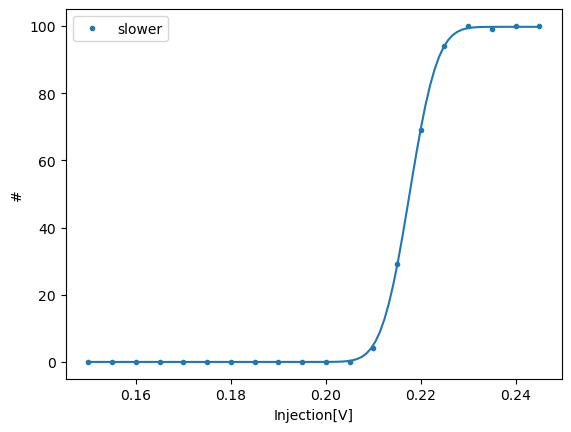

In [73]:
## get data from hit file (event_data)
with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator0
dat0 = dat[dat['comp']==0]
if len(dat0)!=0:
    ## take only the first data (delete hits from the rising edges)
    uni, idx= np.unique(dat0['timestamp'], return_index=True)
    dat0 = dat0[idx]
    ## count hits per event_number
    nhit = np.bincount(dat0['event_number'])

    # make a plot (injection vs n of hits)
    plt.plot(param['inj'], nhit, '.', label='faster')

## select hits from comparator1
dat1 = dat[dat['comp']==1]
if len(dat1)!=0:
#print(dat1)
    uni, idx = np.unique(dat1['timestamp'], return_index=True)
    dat1 = dat1[idx]
    nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))
    fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
    x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
    plt.plot(x, fitfunc.scurve(x,*fit[:3]), '-')
    plt.plot(param['inj'], nhit1, 'C0.', label='slower')

## show x-axis and y-axis and legend
plt.xlabel('Injection[V]')
plt.ylabel('#')
plt.legend()

## print threshold
print('th={0:.3f} th_sigma={1:.3f} Vinj'.format(fit[1], fit[2]))

## Timewalk 

100 12


(250.0, 375.0)

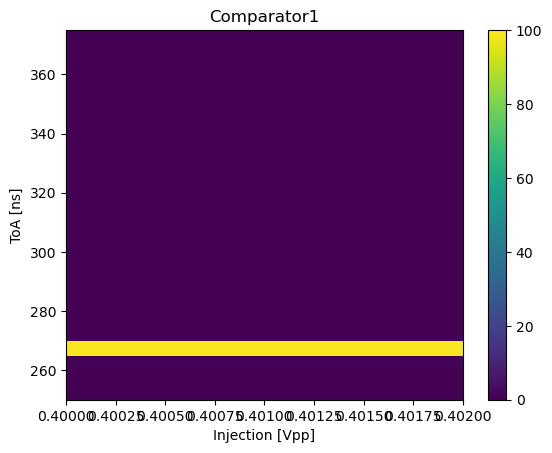

In [12]:
## timewalk
## define the 2D array
n = 100 #2**11
nsteps = param.shape[0]
print(n, nsteps)
toa = np.empty([n, nsteps])
# for each step (event_number)
for i in range(nsteps):
    ## select hit in each event_number
    ev = dat0[dat0['event_number']==i]
    tmp = np.array([
            ev['col']==col,
            ev['row']==row])
    ev = ev[np.all(tmp, axis=0)]
    ## make a histogram in each evevent
    toa[:,i] = np.bincount(ev['toa'], minlength=n)[:n]
    #print(ev['toa'], toa[:, i])
    
# plot 
plt.imshow(toa, origin='lower', extent=(param['inj'][0]/10., param['inj'][-1]/10., 0, n*5), aspect='auto')
plt.xlabel('Injection [Vpp]')
plt.ylabel('ToA [ns]')
plt.title('Comparator1')
plt.colorbar()
plt.xlim(0.4, 0.4+0.0020)
plt.ylim(250, 375)

#### text text text

Text(0.5, 1.0, 'Comparator2')

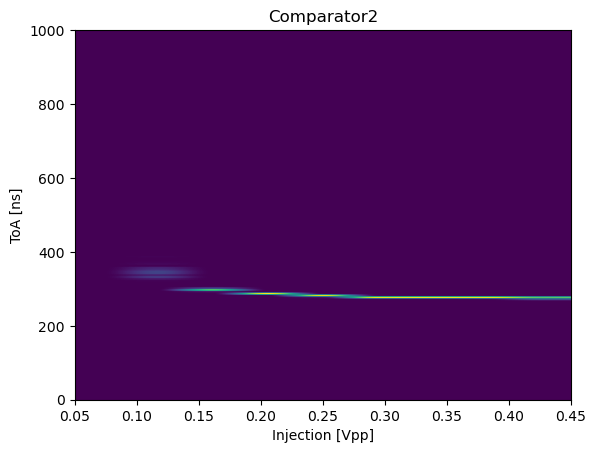

In [18]:
## timewalk
n = 200 #2**11
nsteps = param.shape[0]
toa = np.empty([n, nsteps])
for i in range(nsteps):
    ev = dat1[dat1['event_number']==i]
    tmp = np.array([
            ev['col']==col,
            ev['row']==row])
    ev = ev[np.all(tmp, axis=0)]
    toa[:,i] = np.bincount(ev['toa'], minlength=n)[:n]

plt.imshow(toa, origin='lower', extent=(param['inj'][0]/10., param['inj'][-1]/10., 0, n*5), aspect='auto')
plt.xlabel('Injection [Vpp]')
plt.ylabel('ToA [ns]')
plt.title('Comparator2')